In [58]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import spacy
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min

In [14]:
nlp = spacy.load('en_core_web_sm')

# 1. Load Data

In [4]:
df = pd.read_csv('../data/nyt_data_20200202.csv')

In [7]:
df['pub_date'] = pd.to_datetime(df['pub_date'])

df = df.drop_duplicates()

In [16]:
df.head()

,byline,headline,pub_date
0,Reuters,One Case of Coronavirus Symptoms Among French ...,2020-02-01 23:58:05
1,The Associated Press,Keyser Scores 23 to Carry NC Central Over SC S...,2020-02-01 23:57:34
2,The Associated Press,Shelton Scores 29 to Carry Northern Arizona Pa...,2020-02-01 23:57:33
3,Reuters,"Russia's Consumer Safety Watchdog, After Repor...",2020-02-01 23:55:04
4,Reuters,A Long and Winding Road: The UK Journey In and...,2020-02-01 23:52:04


In [12]:
df.shape

(870, 3)

# 2. Text Analysis

To give meaning to independent words and, consequently, whole sentences, we’ll use SpaCy’s pre-trained word embeddings models. More specifically, SpaCy’s large model (en_core_web_lg), which has pre-trained word vectors for 685k English words. Alternatively, you could be using any pre-trained word representation model (Word2Vec, FastText, GloVe…).

By default, SpaCy considers a sentence’s vector as the average between every word’s vector. It’s a simplistic approach that doesn’t take into account the order of words to determine a sentence’s vector.

In [17]:
sent_vecs = {}
docs = []

for headline in tqdm_notebook(df['headline']):
    doc = nlp(headline)
    docs.append(doc)
    sent_vecs.update({'headline': doc.vector})

sentences = list(sent_vecs.keys())
vectors = list(sent_vecs.values())

# 3. Clustering

The epsilon parameter determines the maximum distance between two samples for them to be considered as in the same neighborhood, meaning that if eps is too big, fewer clusters will be formed, but also if it’s too small, most of the points will be classified as not belonging to a cluster (-1), which will result in a few clusters as well.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [45]:
x = np.array(vectors)

n_classes = {}

for i in tqdm_notebook(np.arange(0.001, 1, 0.001)):
    dbscan = DBSCAN(eps=i, 
                    min_samples=1,
                    metric='cosine').fit(x)
    n_classes.update({i: len(pd.Series(dbscan.labels_).value_counts())})

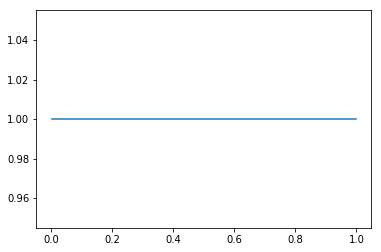

In [46]:
plt.plot(n_classes.keys(), n_classes.values())
plt.show()

Tunning eps value might be one of the most delicate steps because the outcome will vary a lot depending on how much you want to consider sentences as similar. The right value will come up with experimentation, trying to find a value that preserves the similarities between sentences without splitting close sentences into different groups.

In general, since we want to end up with very similar sentences in the same cluster, the target should be a value that returns a higher number of classes

In [48]:
dbscan = DBSCAN(eps=0.08, 
                min_samples=2,
                metric='cosine').fit(x)
dbscan

DBSCAN(algorithm='auto', eps=0.08, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=2, n_jobs=None, p=None)

In [52]:
result = pd.DataFrame({'label': dbscan.labels_,
                      'sent': sentences})
example_result = result[result['label'] == 1].sent.tolist()
event_df = df[df['headline'].isin(example_result)][['pub_date', 'headline']]
event_df['pub_date'] = pd.to_datetime(event_df['pub_date'])
event_df = event_df.sort_values(by='pub_date').dropna()

# 4. Transform to Events

Next step is to arrange those sentences in time and to filter them by relevance. 

Since there are many titles about the same topic every day, we need a criterium to pick one among them. It should be the sentence that best represents the event, one that comprises the core message which those titles refer to.

In order to achieve that, we can group the daily sentences, and for each group (or cluster), choose the one closest to the cluster center.

In [60]:
def get_mean_vector(sents):
    a = np.zeros(300)
    for sent in sents:
        a = a+nlp(sent).vector
    return a/len(sents)

def get_central_vector(sents):
    vecs = []
    for sent in sents:
        doc = nlp(title)
        vecs.append(doc.vector)
    mean_vec = get_mean_vector(sents)
    index = pairwise_distances_argmin_min(np.array([mean_vec]),
                                         vecs)[0][0]
    return sents[index]
